## Árvores de regressão - exercícios 02

Este exercício será uma continuação do anterior, mesma base, mesmas variáveis - vamos tentar buscar a 'melhor árvore'.


*Atenção - Utilizar a base de dados em anexo que é a mesma base que utilizamos na atividade anterior! A base Boston, assim como para a primeira atividade foi descontinuada e não deve ser utilizada*

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split

### 1. Execute os passos do exercício anterior, até que você tenha uma árvore de regressão predizendo o valor do imóvel na base de treinamento.

In [17]:
df = pd.read_csv('housing.csv')

df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())

if 'ocean_proximity' in df.columns:
    df = pd.get_dummies(df, columns=['ocean_proximity'])

X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_final, y_train_final)

DecisionTreeRegressor(random_state=42)

### 2.  Calcule o caminho indicado pelos CCP-alfas dessa árvore.

In [18]:
path = tree.cost_complexity_pruning_path(X_train_final, y_train_final)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

print("Valores de CCP alphas:")
print(ccp_alphas)

print("\nImpunidades associadas a cada alpha:")
print(impurities)

Valores de CCP alphas:
[0.00000000e+00 3.58958577e-05 4.03746770e-05 ... 7.75059667e+08
 1.64852885e+09 4.16020379e+09]

Impunidades associadas a cada alpha:
[0.00000000e+00 7.17917154e-05 1.12166392e-04 ... 7.43732404e+09
 9.08585288e+09 1.32460567e+10]


### 3. Paca cada valor de alpha obtido no item 2, treine uma árvore com o respectivo alfa, e guarde essa árvore em uma lista.

In [19]:
limite_alfa = np.percentile(ccp_alphas, 90)

ccp_alphas_filtrados = ccp_alphas[ccp_alphas <= limite_alfa]


In [20]:
ccp_alphas_sample = np.linspace(ccp_alphas_filtrados.min(), ccp_alphas_filtrados.max(), 20)

trees_pruned = []

for ccp_alpha in ccp_alphas_sample:
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train_final, y_train_final)
    trees_pruned.append(tree)

print(f"Treinadas {len(trees_pruned)} árvores com diferentes valores de ccp_alpha (amostrados).")


Treinadas 20 árvores com diferentes valores de ccp_alpha (amostrados).


### 4. Para cada árvore na lista, calcule o MSE da árvore.

In [21]:
from sklearn.metrics import mean_squared_error

mses_val = []

for tree in trees_pruned:
    y_pred = tree.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mses_val.append(mse)

for i, (alpha, mse) in enumerate(zip(ccp_alphas_sample, mses_val)):
    print(f"{i+1:2d}. ccp_alpha = {alpha:.6f} → MSE (validação): {mse:.2f}")


 1. ccp_alpha = 0.000000 → MSE (validação): 4783223630.57
 2. ccp_alpha = 26739.215296 → MSE (validação): 4753166474.90
 3. ccp_alpha = 53478.430592 → MSE (validação): 4743761104.45
 4. ccp_alpha = 80217.645888 → MSE (validação): 4712356232.63
 5. ccp_alpha = 106956.861184 → MSE (validação): 4670929976.95
 6. ccp_alpha = 133696.076480 → MSE (validação): 4658759663.54
 7. ccp_alpha = 160435.291776 → MSE (validação): 4650025697.52
 8. ccp_alpha = 187174.507072 → MSE (validação): 4625369119.12
 9. ccp_alpha = 213913.722368 → MSE (validação): 4597855922.49
10. ccp_alpha = 240652.937664 → MSE (validação): 4581986639.26
11. ccp_alpha = 267392.152960 → MSE (validação): 4549514853.27
12. ccp_alpha = 294131.368257 → MSE (validação): 4527483274.90
13. ccp_alpha = 320870.583553 → MSE (validação): 4493316863.87
14. ccp_alpha = 347609.798849 → MSE (validação): 4473906902.10
15. ccp_alpha = 374349.014145 → MSE (validação): 4477845098.26
16. ccp_alpha = 401088.229441 → MSE (validação): 4470334796.09


### 5. Monte um gráfico do MSE pelo alpha, escolha um valor de alpha perto do ponto de mínimo do MSE

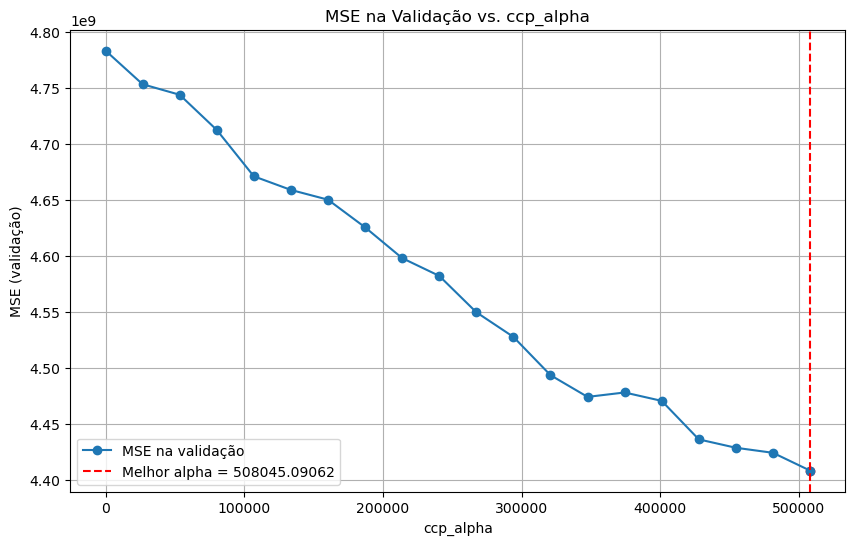

In [22]:
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas_sample, mses_val, marker='o', label='MSE na validação')

idx_melhor_alpha = np.argmin(mses_val)
melhor_alpha = ccp_alphas_sample[idx_melhor_alpha]
melhor_mse = mses_val[idx_melhor_alpha]

plt.axvline(melhor_alpha, color='red', linestyle='--', label=f'Melhor alpha = {melhor_alpha:.5f}')
plt.scatter(melhor_alpha, melhor_mse, color='red')
plt.xlabel('ccp_alpha')
plt.ylabel('MSE (validação)')
plt.title('MSE na Validação vs. ccp_alpha')
plt.legend()
plt.grid(True)
plt.show()

### 6. Calcule o R-quadrado dessa árvore encontrada no item acima

In [23]:
from sklearn.metrics import r2_score

idx_melhor_alpha = np.argmin(mses_val)

melhor_arvore = trees_pruned[idx_melhor_alpha]

r2_val = melhor_arvore.score(X_val, y_val)

r2_train = melhor_arvore.score(X_train_final, y_train_final)

print(f"R² na validação: {r2_val:.4f}")
print(f"R² no treino:     {r2_train:.4f}")


R² na validação: 0.6790
R² no treino:     0.9572


### 7. Visualize esta árvore.

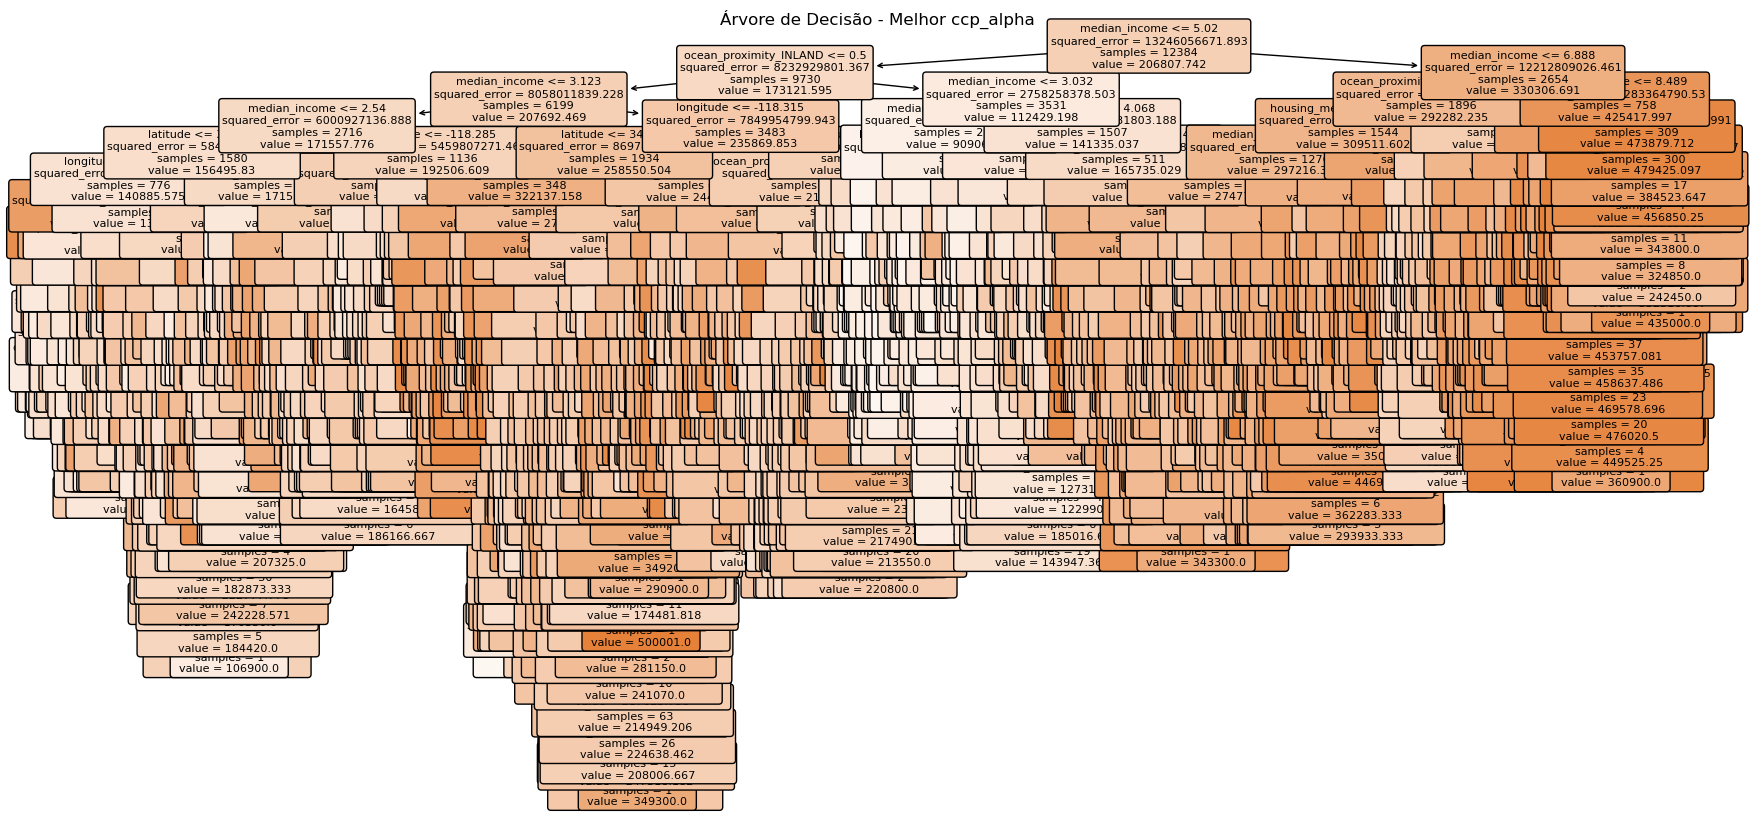

In [25]:
plt.figure(figsize=(20,10))
plot_tree(
    melhor_arvore, 
    filled=True, 
    feature_names=X_train_final.columns, 
    rounded=True,
    fontsize=8
)
plt.title("Árvore de Decisão - Melhor ccp_alpha")
plt.show()


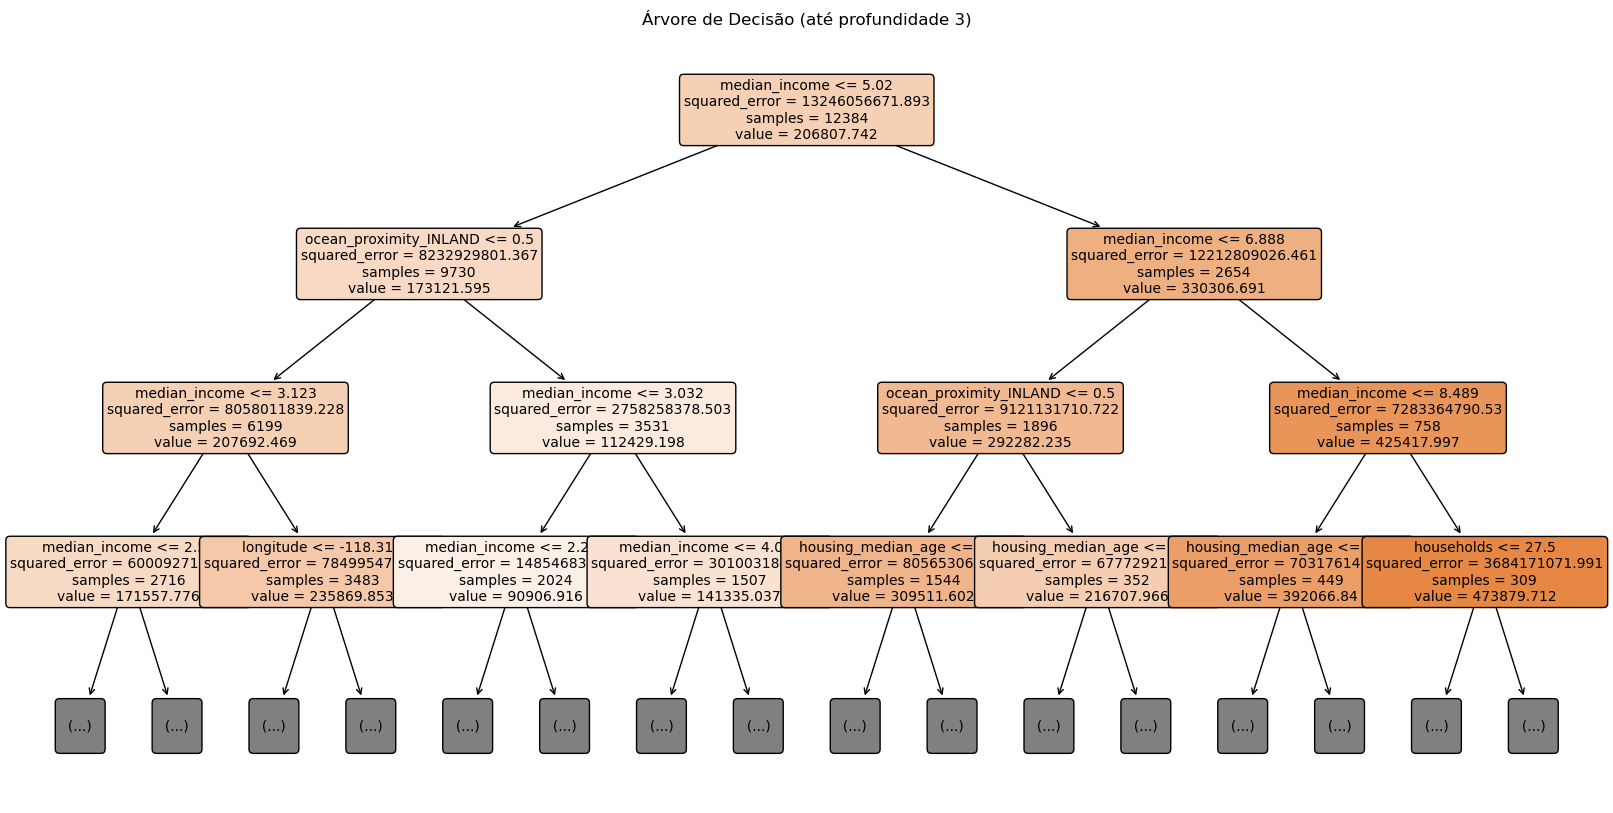

In [26]:
plt.figure(figsize=(20, 10))
plot_tree(
    melhor_arvore, 
    filled=True, 
    feature_names=X_train_final.columns,
    rounded=True,
    fontsize=10,
    max_depth=3  
)
plt.title("Árvore de Decisão (até profundidade 3)")
plt.show()
